In [1]:
import sys
import jax
import time
import genjax
import bayes3d as b
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
sys.path.append("../")
from viz import *
from utils import *
from mcs_utils import *
from PIL import Image
import bayes3d.transforms_3d as t3d
from jax.debug import print as jprint
from tqdm import tqdm
import jax.tree_util as jtu
from genjax._src.core.transforms.incremental import NoChange, UnknownChange, Diff
console = genjax.pretty()

In [2]:
# Loading and preprocessing all data and renderer
SCALE = 0.1
observations = load_observations_npz('passive_physics_validation_shape_constancy_0001_01')
gt_images, gt_images_bg, gt_images_obj, intrinsics, registered_objects = preprocess_mcs_physics_scene(observations, MIN_DIST_THRESH=0.6, scale=SCALE)
b.setup_renderer(intrinsics)
for registered_obj in registered_objects:
    b.RENDERER.add_mesh(registered_obj['mesh'])
video_from_rendered(gt_images, scale = int(1/SCALE), framerate=30)

Extracting Meshes


 58%|█████▊    | 93/160 [00:12<00:22,  2.99it/s]

Adding review
Review passed, added to init queue
Adding new mesh for t = {} 92


100%|██████████| 160/160 [00:33<00:00,  4.78it/s]


Extracting downsampled data


[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (64, 64, 1024)
Centering mesh with translation [0.01000004 0.01249996 0.01249991]


<IPython.core.display.HTML object>

In [49]:
# model time
# This model has to be recompiled for different # objects for now this is okay
@genjax.gen
def mcs_single_object(prev_state, t_inits, init_poses, pose_update_params, variance, outlier_prob):
    """
    Single Object Model HMM
    """

    (_, _, poses, active_states, t) = prev_state

    num_objects = poses.shape[0]
    
    # for each object
    for i in range(num_objects):
        # This is where the physics model will go
        # POSSIBLE BUG ALERT --> pose decorator may be in the wrong place, will be an issue for multiple objs
        updated_pose = b.gaussian_vmf_pose(poses[i], *pose_update_params)  @ "pose"
        poses = poses.at[i].set(updated_pose)
        # activate object when t == t_init for that object and initialize the correct pose
        active_states = active_states.at[i].set(jax.lax.cond(
            jnp.equal(t_inits[i]+1,t), # doing t_init + 1 so in first time step, the pose is fixed 
            lambda:True, 
            lambda:active_states[i]))
        
        poses = poses.at[i].set(jax.lax.cond(
            jnp.equal(t_inits[i],t), # init pose at the corerct time step
            lambda:init_poses[i], 
            lambda:poses[i]))
        # jprint("t = {}, pose is {}",t, poses[0][:3,3])
        # pose_update_params = jax.lax.cond(active_states[i],lambda:pose_update_params,lambda:jnp.array([1e+20, 0]))
        # put the pose so far away that any pose update cant possibel come intot he scene
        # We will use the active_states for genjax branch switching


    # jprint("t = {}, pose is {}",t, poses[0][:3,3])
    rendered_image_obj = b.RENDERER.render(
        poses, jnp.arange(num_objects))[...,:3]

    # NOTE: gt_images_bg is a global variable here as it consumes too much memory for the trace
    rendered_image = splice_image(rendered_image_obj, gt_images_bg[t])

    sampled_image = b.image_likelihood(rendered_image, variance, outlier_prob) @ "depth"

    return (rendered_image, rendered_image_obj, poses, active_states, t+1)

In [55]:
def pose_update_v4(key, trace_, pose_grid, enumerator):
    
    weights = enumerator.enumerate_choices_get_scores(trace_, key, pose_grid)
    sampled_idx = weights.argmax() # jax.random.categorical(key, weights)
    # jprint("weights = {}",weights)
    # jprint("idx chosen = {}",sampled_idx)
    return *enumerator.update_choices_with_weight(
        trace_, key,
        pose_grid[sampled_idx]
    ), pose_grid[sampled_idx]


pose_update_v4_jit = jax.jit(pose_update_v4, static_argnames=("enumerator",))


def c2f_pose_update_v4(key, trace_, gridding_schedule_stacked, enumerator, t, addr):

    # reference = trace_[addr][t-1]
    reference = trace_.get_retval()[2][t-1][0] # note that poses' shape is now (1,4,4)
    for i in range(len(gridding_schedule_stacked)):
        updated_grid = jnp.einsum("ij,ajk->aik", reference, gridding_schedule_stacked[i])
        weight, trace_, reference = pose_update_v4_jit(key, trace_, updated_grid, enumerator)
    # jprint("t = {}, weight = {}",t,weight)
    # jprint("t = {}",t)

    return weight, trace_

c2f_pose_update_v4_vmap_jit = jax.jit(jax.vmap(c2f_pose_update_v4, in_axes=(0,0,None,None,None)),
                                    static_argnames=("enumerator", "t", "addr"))

c2f_pose_update_v4_jit = jax.jit(c2f_pose_update_v4,static_argnames=("enumerator", "t", "addr"))

def make_new_keys(key, N_keys):
    key, other_key = jax.random.split(key)
    new_keys = jax.random.split(other_key, N_keys)
    if N_keys > 1:
        return key, new_keys
    else:
        return key, new_keys[0]


def update_choice_map(gt_depths, constant_choices, t):
    constant_choices['depth'] = gt_depths[t][None,...]
    return genjax.index_choice_map(
            [t], genjax.choice_map(
                constant_choices
            )
        )

def argdiffs_modelv6(trace, t):
    """
    Argdiffs specific to modelv6
    """
    # print(trace.args)
    args = trace.get_args()
    argdiffs = (
        Diff(t, UnknownChange),
        jtu.tree_map(lambda v: Diff(v, NoChange), args[1]),
        *jtu.tree_map(lambda v: Diff(v, NoChange), args[2:]),
    )
    return argdiffs

def proposal_choice_map(addresses, args, chm_args):
    addr = addresses[0] # custom defined
    return genjax.index_choice_map(
                    jnp.array([chm_args[0]]),genjax.choice_map({
                        addr: jnp.expand_dims(args[0], axis = 0)
            }))

In [51]:
def inference_approach_F3(model, gt, gridding_schedule, init_chm, model_args, init_state, key, constant_choices, T, addr):
    """
    Sequential Importance Sampling on the unfolded HMM model
    with 3D pose enumeration proposal

    WITH JUST ONE PARTICLE
    """
    # extract data

    key, init_key = make_new_keys(key, 1)

    # define functions for SIS/SMC
    init_fn = model.importance
    update_fn = jax.jit(model.update)
    proposal_fn = c2f_pose_update_v4_jit

    # initialize SMC/SIS
    init_log_weight, init_particle = init_fn(init_key, init_chm, (0, init_state, *model_args))
    # _,_, init_particle, _ = update_fn(init_key, init_particle, genjax.index_choice_map(
    #         [0], genjax.choice_map(
    #             {'velocity' : jnp.expand_dims(init_state[-1], axis = 0)}
    #         )),
    #         argdiffs_modelv6(init_particle, 0))
    

    # argdiffs = argdiffs_modelv6(init_particle, 0)
    # _, init_log_weight, init_particle, _ = update_fn(
    #         init_key, init_particle, update_choice_map(gt, constant_choices, 0), argdiffs)
    

    def smc_body(state, t):
        # get new keys
        print("jit compiling")
        # jprint("t = {}",t)
        key, log_weight, particle = state
        key, update_key = make_new_keys(key, 1)
        key, proposal_key = make_new_keys(key, 1)

        argdiffs = argdiffs_modelv6(particle, t)

        # make enumerator for this time step (affects the proposal choice map)
        enumerator = b.make_enumerator([(addr)], 
                                        chm_builder = proposal_choice_map,
                                        argdiff_f=lambda x: argdiffs,
                                        chm_args = [t])

        # update model to new depth observation
        _, update_log_weight, updated_particle, _ = update_fn(
            update_key, particle, update_choice_map(gt,constant_choices, t), argdiffs)

        # propose good poses based on proposal
        proposal_log_weight, new_particle = proposal_fn(
            proposal_key, updated_particle, gridding_schedule, enumerator, t, addr)

        # get weight of particle
        new_log_weight = log_weight + proposal_log_weight + update_log_weight

        return (key, new_log_weight, new_particle), None

    (_, final_log_weight, particle), _ = jax.lax.scan(
        smc_body, (key, init_log_weight, init_particle), jnp.arange(1, T+1))
    print("SCAN finished")
    rendered = particle.get_retval()[0]
    return final_log_weight, particle, rendered

In [53]:
# enumeration grid
# TODO: ADAPTIVE GRID SIZING
grid_widths = [0.25, 0.125,0.0625]
grid_nums = [(5,5,5),(5,5,5),(5,5,5)]
gridding_schedule_trans = make_schedule_translation_3d(grid_widths, grid_nums)
gridding_schedule_rot = [b.utils.make_rotation_grid_enumeration(10, 15, -jnp.pi/12, jnp.pi/12, jnp.pi/12)]
gridding_schedule = [gridding_schedule_trans[0], gridding_schedule_trans[1], gridding_schedule_trans[2], gridding_schedule_rot[0]]

# Setup for inference
T = gt_images.shape[0]
num_registered_objects = len(registered_objects)
INIT_STATE = (
        gt_images[0],
        gt_images_obj[0],
        jnp.tile(jnp.eye(4).at[2,3].set(1e+5)[None,...],(num_registered_objects,1,1)),
        # registered_objects[0]['pose'][None,...],
        jnp.zeros(num_registered_objects, dtype=bool),
        0
)
MODEL_ARGS = (
     jnp.array([registered_obj['t'] for r in registered_objects]),
     jnp.array([registered_obj['pose'] for r in registered_objects]),
     jnp.array([1e+20, 0]),
     0.1,
     None
)
CONSTANT_CHOICES = {}

init_chm = update_choice_map(gt_images, CONSTANT_CHOICES, 0)
key = jax.random.PRNGKey(45675456)

model_unfold = genjax.UnfoldCombinator.new(mcs_single_object, T)
inference_approach_F3_jit = jax.jit(inference_approach_F3, static_argnames=("T", "addr"))

start = time.time()
lw, tr, rendered = inference_approach_F3_jit(model_unfold, gt_images, 
    gridding_schedule, init_chm, MODEL_ARGS, INIT_STATE, key, CONSTANT_CHOICES, T, "pose")
print ("FPS:", rendered.shape[0] / (time.time() - start))

# print(tr.get_retval()[2][93][0,:3,3])

jit compiling
SCAN finished
t = 1
weights = [-268.3905 -268.3905 -268.3905 -268.3905 -268.3905 -268.3905 -268.3905
 -268.3905 -268.3905 -268.3905 -268.3905 -268.3905 -268.3905 -268.3905
 -268.3905 -268.3905 -268.3905 -268.3905 -268.3905 -268.3905 -268.3905
 -268.3905 -268.3905 -268.3905 -268.3905 -268.3905 -268.3905 -268.3905
 -268.3905 -268.3905 -268.3905 -268.3905 -268.3905 -268.3905 -268.3905
 -268.3905 -268.3905 -268.3905 -268.3905 -268.3905 -268.3905 -268.3905
 -268.3905 -268.3905 -268.3905 -268.3905 -268.3905 -268.3905 -268.3905
 -268.3905 -268.3905 -268.3905 -268.3905 -268.3905 -268.3905 -268.3905
 -268.3905 -268.3905 -268.3905 -268.3905 -268.3905 -268.3905 -268.3905
 -268.3905 -268.3905 -268.3905 -268.3905 -268.3905 -268.3905 -268.3905
 -268.3905 -268.3905 -268.3905 -268.3905 -268.3905 -268.3905 -268.3905
 -268.3905 -268.3905 -268.3905 -268.3905 -268.3905 -268.3905 -268.3905
 -268.3905 -268.3905 -268.3905 -268.3905 -268.3905 -268.3905 -268.3905
 -268.3905 -268.3905 -268.3905 -2

In [56]:
video_comparison_from_images(tr.get_retval()[0], gt_images)

<IPython.core.display.HTML object>

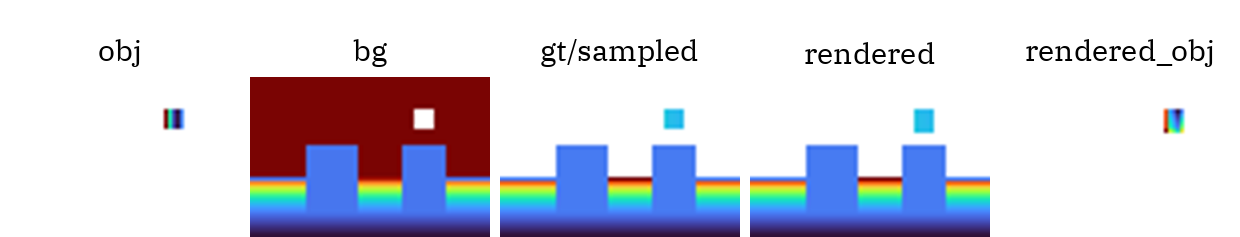

In [60]:
t = 97
b.multi_panel([b.scale_image(b.get_depth_image(gt_images_obj[t][...,2]),4),
               b.scale_image(b.get_depth_image(gt_images_bg[t][...,2]),4),
               b.scale_image(b.get_depth_image(gt_images[t][...,2]),4),
               b.scale_image(b.get_depth_image(tr.get_retval()[0][t][...,2]),4),
               b.scale_image(b.get_depth_image(tr.get_retval()[1][t][...,2]),4)
               ],labels = ['obj', 'bg', 'gt/sampled', 'rendered', 'rendered_obj'])

In [64]:
images = []
for t in range(T):
    images.append(b.multi_panel([b.scale_image(b.get_depth_image(gt_images_obj[t][...,2]),4),
                b.scale_image(b.get_depth_image(gt_images_bg[t][...,2]),4),
                b.scale_image(b.get_depth_image(gt_images[t][...,2]),4),
                b.scale_image(b.get_depth_image(tr.get_retval()[0][t][...,2]),4),
                b.scale_image(b.get_depth_image(tr.get_retval()[1][t][...,2]),4)
                ],labels = ['obj', 'bg', 'gt/sampled', 'rendered', 'rendered_obj']))
display_video(images, framerate=30)

<IPython.core.display.HTML object>

In [ ]:
gt_images_obj[93][...,2][3]

In [ ]:
tr.get_retval()[2][93]

In [ ]:
tr['pose'][92]

In [ ]:
model_unfold = genjax.UnfoldCombinator.new(mcs_single_object, T)
model_unfold.importance(key, full_chm, (T-1, INIT_STATE, *MODEL_ARGS))

In [18]:
b.gaussian_vmf_pose.logpdf(jnp.eye(4), jnp.eye(4).at[:3,3].set([34345345,345345345,34534534]), 1e+20, 0)

Array(-143.89453, dtype=float32)